In [1]:
import torch
from torch import nn, optim
import numpy as np
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
import math

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
print(torch.cuda.device_count())
print(torch.cuda.is_available())
print(torch.version.cuda)

1
True
11.8


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [5]:
import random

#Set seed
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [6]:
'''
class TimeSeriesDataset(Dataset):
    def __init__(self, root_dir, transform=None):

        root_dir='./Label_DATA'
        self.data = []
        self.labels = []
        self.label_map = {'No Force': 0, 'Applying Force': 1, 'Deforming': 2, 'Releasing Force': 3}
        self.transform = transform

        # 각 라벨별로 데이터 로드
        for label, idx in self.label_map.items():
            label_dir = os.path.join(root_dir, label)
            for fname in os.listdir(label_dir):
                file_path = os.path.join(label_dir, fname)
                time_series = np.loadtxt(file_path, delimiter=',')
                time_series = torch.tensor(time_series, dtype=torch.float32)
                self.data.append(time_series)
                self.labels.append(idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        if self.transform:
            data = self.transform(data)
        return data, self.labels[idx]
'''

"\nclass TimeSeriesDataset(Dataset):\n    def __init__(self, root_dir, transform=None):\n\n        root_dir='./Label_DATA'\n        self.data = []\n        self.labels = []\n        self.label_map = {'No Force': 0, 'Applying Force': 1, 'Deforming': 2, 'Releasing Force': 3}\n        self.transform = transform\n\n        # 각 라벨별로 데이터 로드\n        for label, idx in self.label_map.items():\n            label_dir = os.path.join(root_dir, label)\n            for fname in os.listdir(label_dir):\n                file_path = os.path.join(label_dir, fname)\n                time_series = np.loadtxt(file_path, delimiter=',')\n                time_series = torch.tensor(time_series, dtype=torch.float32)\n                self.data.append(time_series)\n                self.labels.append(idx)\n\n    def __len__(self):\n        return len(self.data)\n\n    def __getitem__(self, idx):\n        data = self.data[idx]\n        if self.transform:\n            data = self.transform(data)\n        return data, 

In [7]:
'''
from torch.utils.data import random_split

# 데이터셋 인스턴스 생성
dataset = TimeSeriesDataset(root_dir='./Label_DATA')


# 데이터셋 크기에 따라 8:2 비율로 분할
#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 데이터로더 설정
#train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

'''

"\nfrom torch.utils.data import random_split\n\n# 데이터셋 인스턴스 생성\ndataset = TimeSeriesDataset(root_dir='./Label_DATA')\n\n\n# 데이터셋 크기에 따라 8:2 비율로 분할\n#train_size = int(0.8 * len(dataset))\n#test_size = len(dataset) - train_size\n#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])\n\n# 데이터로더 설정\n#train_loader = DataLoader(train_dataset, batch_size, shuffle=True)\n#test_loader = DataLoader(test_dataset, batch_size, shuffle=False)\n\ntrain_size = int(0.7 * len(dataset))\nval_size = int(0.2 * len(dataset))\ntest_size = len(dataset) - train_size - val_size\ntrain_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])\n\n"

In [8]:
'''
from torch.nn.utils.rnn import pad_sequence

# 데이터 변환 예: 패딩과 배치 단위 처리
class PadSequence:
    def __call__(self, batch):
        # batch 내의 시계열 데이터를 Tensor 리스트로 준비
        data = [item[0] for item in batch]
        labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
        data = pad_sequence(data, batch_first=True, padding_value=0)
        return data, labels


# 데이터로더에서 이 변환 사용
#train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=PadSequence())
#test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=PadSequence())
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=PadSequence())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=PadSequence())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=PadSequence())
'''

'\nfrom torch.nn.utils.rnn import pad_sequence\n\n# 데이터 변환 예: 패딩과 배치 단위 처리\nclass PadSequence:\n    def __call__(self, batch):\n        # batch 내의 시계열 데이터를 Tensor 리스트로 준비\n        data = [item[0] for item in batch]\n        labels = torch.tensor([item[1] for item in batch], dtype=torch.long)\n        data = pad_sequence(data, batch_first=True, padding_value=0)\n        return data, labels\n\n\n# 데이터로더에서 이 변환 사용\n#train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=PadSequence())\n#test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=PadSequence())\nbatch_size = 64\ntrain_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=PadSequence())\nval_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=PadSequence())\ntest_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=PadSequence())\n'

In [9]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


class TimeSeriesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        root_dir = './Label_DATA_Teacher1'
        self.data = []
        self.labels = []
        self.file_paths = []
        self.label_map = {'No Force': 0, 'Applying Force': 1, 'Deforming': 2, 'Releasing Force': 3}
        self.transform = transform

        for label, idx in self.label_map.items():
            label_dir = os.path.join(root_dir, label)
            for fname in os.listdir(label_dir):
                file_path = os.path.join(label_dir, fname)
                #데이터셋 예외처리
                try:
                    time_series = np.loadtxt(file_path, delimiter=',')
                    if time_series.shape[1] != 3 or len(time_series.shape) != 2:
                        raise ValueError(f"Unexpected data shape in file {file_path}: {time_series.shape}")
                    time_series = torch.tensor(time_series, dtype=torch.float32)
                    self.data.append(time_series)
                    self.labels.append(idx)
                    self.file_paths.append(file_path)
                except Exception as e:
                    print(f"Error loading file {file_path}: {e}")

                # time_series = np.loadtxt(file_path, delimiter=',')
                # time_series = torch.tensor(time_series, dtype=torch.float32)
                # self.data.append(time_series)
                # self.labels.append(idx)
                # self.file_paths.append(file_path)  # 파일 경로 추가

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        if self.transform:
            data = self.transform(data)
        # 데이터, 레이블, 파일 경로를 반환
        return data, self.labels[idx], self.file_paths[idx]
    
class PadSequence:
    def __call__(self, batch):
        # batch 내의 시계열 데이터를 Tensor 리스트로 준비
        data = [item[0] for item in batch]
        labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
        data = pad_sequence(data, batch_first=True, padding_value=0)
        file_paths = [item[2] for item in batch]
        return data, labels, file_paths
    
def create_data_loaders(dataset, train_size=0.7, val_size=0.2, test_size=0.1, batch_size=64):
    # 데이터 인덱스 생성
    indices = list(range(len(dataset)))
    
    # 훈련, 검증, 테스트 데이터셋 인덱스 분할
    train_val_idx, test_idx = train_test_split(indices, test_size=test_size, stratify=dataset.labels)
    train_idx, val_idx = train_test_split(train_val_idx, test_size=val_size / (train_size + val_size), stratify=[dataset.labels[i] for i in train_val_idx])
    
    # 데이터 로더 생성
    train_loader = DataLoader(Subset(dataset, train_idx), batch_size=batch_size, shuffle=True, collate_fn=PadSequence())
    val_loader = DataLoader(Subset(dataset, val_idx), batch_size=batch_size, shuffle=False, collate_fn=PadSequence())
    test_loader = DataLoader(Subset(dataset, test_idx), batch_size=batch_size, shuffle=False, collate_fn=PadSequence())
    
    return train_loader, val_loader, test_loader

# 데이터셋 인스턴스 생성
dataset = TimeSeriesDataset(root_dir ='./Label_DATA_Teacher1')
train_loader, val_loader, test_loader = create_data_loaders(dataset)


In [10]:
def count_labels(data_loader):
    label_count = {0: 0, 1: 0, 2: 0, 3: 0}
    for _, labels, _ in data_loader:
        # print("Batch labels shape:", labels.shape)
        for label in labels:
            # print("Label:", label)
            label_count[int(label)] += 1
    return label_count

# 각 데이터셋의 라벨 분포 확인
train_label_count = count_labels(train_loader)
val_label_count = count_labels(val_loader)
test_label_count = count_labels(test_loader)

print("Train label distribution:", train_label_count)
print("Validation label distribution:", val_label_count)
print("Test label distribution:", test_label_count)

Train label distribution: {0: 402, 1: 380, 2: 380, 3: 367}
Validation label distribution: {0: 115, 1: 109, 2: 109, 3: 104}
Test label distribution: {0: 58, 1: 54, 2: 55, 3: 52}


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class TemporalConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1):
        super(TemporalConv, self).__init__()
        pad = (kernel_size + (kernel_size - 1) * (dilation - 1) - 1) // 2
        self.conv = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            padding=pad,
            stride=stride,
            dilation=dilation)

        self.bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x

class MultiScaleTCN(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 num_classes,
                 kernel_size,
                 stride=1,
                 dilations=(1, 8),
                 residual=True,
                 residual_kernel_size=1):

        super().__init__()
        assert out_channels % (len(dilations) + 2) == 0, '# out channels should be multiples of # branches (6x)'

        # Multiple branches of temporal convolution
        self.num_branches = len(dilations) + 2
        branch_channels = out_channels // self.num_branches
        if isinstance(kernel_size, list):
            assert len(kernel_size) == len(dilations)
        else:
            kernel_size = [kernel_size] * len(dilations)

        # Temporal Convolution branches
        self.branches = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(
                    in_channels,
                    branch_channels,
                    kernel_size=1,
                    padding=0),
                nn.BatchNorm1d(branch_channels),
                nn.ReLU(inplace=True),
                TemporalConv(
                    branch_channels,
                    branch_channels,
                    kernel_size=ks,
                    stride=stride,
                    dilation=dilation),
            )
            for ks, dilation in zip(kernel_size, dilations)
        ])

        # Additional Max & 1x1 branch
        self.branches.append(nn.Sequential(
            nn.Conv1d(in_channels, branch_channels, kernel_size=1, padding=0),
            nn.BatchNorm1d(branch_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm1d(branch_channels)
        ))

        self.branches.append(nn.Sequential(
            nn.Conv1d(in_channels, branch_channels, kernel_size=1, padding=0, stride=stride),
            nn.BatchNorm1d(branch_channels)
        ))

        # Residual connection
        if not residual:
            self.residual = lambda x: 0
        elif (in_channels == out_channels) and (stride == 1):
            self.residual = lambda x: x
        else:
            self.residual = TemporalConv(in_channels, out_channels, kernel_size=residual_kernel_size, stride=stride)

        # 최종 분류 레이어
        self.fc = nn.Linear(out_channels, num_classes)

    def forward(self, x):
        """
        x: tensor with shape [B, T, C]
        """
        x = x.permute(0, 2, 1)  # (B, T, C) -> (B, C, T)
        print(x.shape)

        res = self.residual(x)
        branch_outs = []
        for temp_conv in self.branches:
            out = temp_conv(x)
            branch_outs.append(out)

        out = torch.cat(branch_outs, dim=1)
        out += res

        out = out.permute(0, 2, 1)  # (B, C, T) -> (B, T, C)
        
        # Temporal 차원을 평균하여 (B, C) 형태로 만들고, 최종 분류 레이어에 통과
        out = torch.mean(out, dim=1)  # (B, T, C) -> (B, C)
        out = self.fc(out)
        return out

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
import torch.nn.functional as F

def custom_loss(outputs, labels):
    softmax_outputs = F.log_softmax(outputs, dim=1)
    return F.nll_loss(softmax_outputs, labels)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 3  # 입력 차원
num_classes = 4  # 클래스 수
num_epochs = 500
learning_rate = 0.0001

model = MultiScaleTCN(in_channels=input_size, out_channels=128, num_classes=num_classes, kernel_size=25, stride=1, dilations=(1, 100), residual=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
criterion = nn.CrossEntropyLoss()


In [15]:
model

MultiScaleTCN(
  (branches): ModuleList(
    (0): Sequential(
      (0): Conv1d(3, 32, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): TemporalConv(
        (conv): Conv1d(32, 32, kernel_size=(25,), stride=(1,), padding=(12,))
        (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Sequential(
      (0): Conv1d(3, 32, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): TemporalConv(
        (conv): Conv1d(32, 32, kernel_size=(25,), stride=(1,), padding=(1200,), dilation=(100,))
        (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Sequential(
      (0): Conv1d(3, 32, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentu

In [16]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): Loss가 개선되지 않는 epoch 수
            min_delta (float): 이전 Loss 대비 개선된 것으로 인정할 최소 감소량
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# 학습 루프에 조기 중단 로직 적용
early_stopping = EarlyStopping(patience=5, min_delta=0.1)

In [17]:
import matplotlib.pyplot as plt

# 학습 및 검증 손실과 정확도를 저장할 리스트
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch in data_loader:
        inputs, labels = batch[:2]
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

def e_model(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in data_loader:
            inputs, labels = batch[:2]
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

# 학습 루프
for epoch in range(num_epochs):
    #scheduler.step()
    train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = e_model(model, val_loader, criterion, device)

    if early_stopping(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)



    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

torch.Size([64, 3, 1338])
torch.Size([64, 3, 3315])
torch.Size([64, 3, 1097])
torch.Size([64, 3, 1446])
torch.Size([64, 3, 1207])
torch.Size([64, 3, 1418])
torch.Size([64, 3, 1586])
torch.Size([64, 3, 1375])
torch.Size([64, 3, 1912])
torch.Size([64, 3, 2785])
torch.Size([64, 3, 1819])
torch.Size([64, 3, 984])
torch.Size([64, 3, 1753])
torch.Size([64, 3, 2326])
torch.Size([64, 3, 1285])
torch.Size([64, 3, 1060])
torch.Size([64, 3, 1671])
torch.Size([64, 3, 493])
torch.Size([64, 3, 1122])
torch.Size([64, 3, 951])
torch.Size([64, 3, 632])
torch.Size([64, 3, 1042])
torch.Size([64, 3, 1520])
torch.Size([57, 3, 960])
torch.Size([64, 3, 1566])
torch.Size([64, 3, 1182])
torch.Size([64, 3, 1724])
torch.Size([64, 3, 1684])
torch.Size([64, 3, 1739])
torch.Size([64, 3, 1326])
torch.Size([53, 3, 729])
Epoch 1, Train Loss: 1.2174, Train Accuracy: 0.3996, Val Loss: 1.3268, Val Accuracy: 0.3318
torch.Size([64, 3, 1005])
torch.Size([64, 3, 2785])
torch.Size([64, 3, 1207])
torch.Size([64, 3, 1400])
torc

In [18]:
'''
epochs = [100, 200, 500, 1000, 2000]

for num_epochs in epochs:
    for epoch in range(num_epochs):
        #scheduler.step()
        train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy = e_model(model, val_loader, criterion, device)

        if early_stopping(val_loss):
            print(f"Early stopping at epoch {epoch+1}")
            break

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
'''

'\nepochs = [100, 200, 500, 1000, 2000]\n\nfor num_epochs in epochs:\n    for epoch in range(num_epochs):\n        #scheduler.step()\n        train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device)\n        val_loss, val_accuracy = e_model(model, val_loader, criterion, device)\n\n        if early_stopping(val_loss):\n            print(f"Early stopping at epoch {epoch+1}")\n            break\n\n        train_losses.append(train_loss)\n        val_losses.append(val_loss)\n        train_accuracies.append(train_accuracy)\n        val_accuracies.append(val_accuracy)\n'

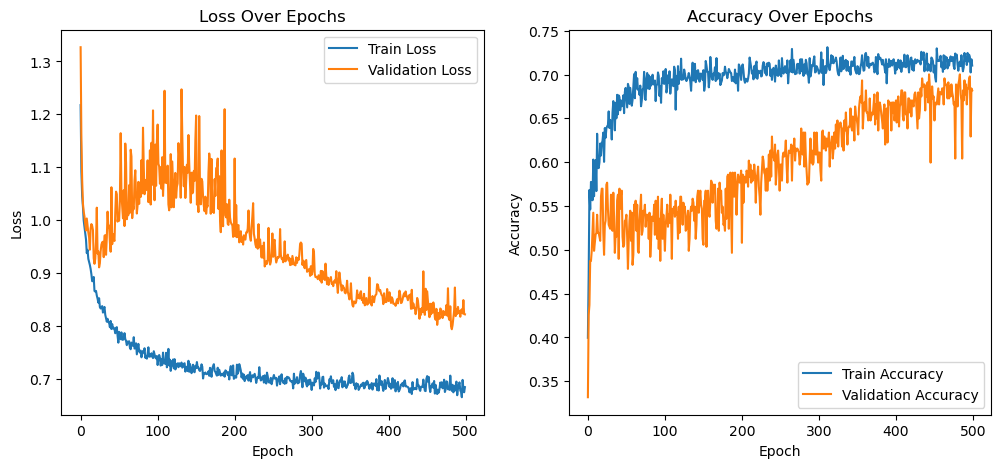

In [19]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

torch.Size([64, 3, 671])
torch.Size([64, 3, 745])
torch.Size([64, 3, 3087])
torch.Size([27, 3, 4355])
              precision    recall  f1-score   support

           0       0.68      0.40      0.50        58
           1       0.41      0.63      0.50        54
           2       0.51      0.51      0.51        55
           3       0.68      0.62      0.65        52

    accuracy                           0.53       219
   macro avg       0.57      0.54      0.54       219
weighted avg       0.57      0.53      0.54       219

Accuracy: 0.5342465753424658


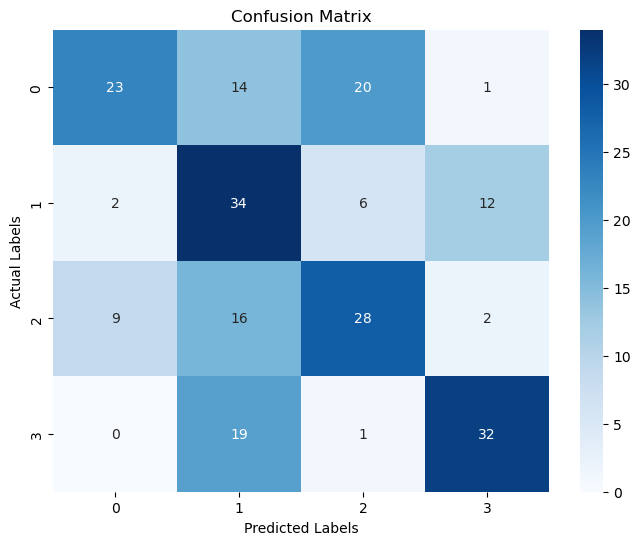

In [20]:
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 모델 평가 함수
def evaluate_model(model, data_loader):
    model.eval()
    true_labels = []
    pred_labels = []
    file_paths = []  # 파일 경로 저장
    with torch.no_grad():
        for inputs, labels, paths in data_loader:
            inputs = inputs.float().to(device)  #입력 데이터를 float 타입으로 변환
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())
            file_paths.extend(paths)  # 파일 경로 추가
    return true_labels, pred_labels, file_paths

# 평가 실행
actual_labels, predicted_labels, file_paths = evaluate_model(model, test_loader)
#for path, true_label, pred_label in zip(file_paths, actual_labels, predicted_labels):
    #print(f'File: {path}, Actual Label: {true_label}, Predicted Label: {pred_label}')

# 성능 메트릭 출력
print(classification_report(actual_labels, predicted_labels))
print("Accuracy:", accuracy_score(actual_labels, predicted_labels))

# 혼동 행렬 생성
cm = confusion_matrix(actual_labels, predicted_labels)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=(0, 1, 2, 3), yticklabels=(0, 1, 2, 3))
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [21]:
# 평가 실행 및 파일 경로 출력
actual_labels, predicted_labels, file_paths = evaluate_model(model, test_loader)

# 실제 레이블과 예측 레이블이 다른 경우만 출력
for path, true_label, pred_label in zip(file_paths, actual_labels, predicted_labels):
    if true_label != pred_label:
        print(f'File: {path}, Actual Label: {true_label}, Predicted Label: {pred_label}')

torch.Size([64, 3, 671])
torch.Size([64, 3, 745])
torch.Size([64, 3, 3087])
torch.Size([27, 3, 4355])
File: ./Label_DATA_Teacher1\Deforming\F27(5844-6001).csv, Actual Label: 2, Predicted Label: 0
File: ./Label_DATA_Teacher1\Releasing Force\F35(1158-1278).csv, Actual Label: 3, Predicted Label: 2
File: ./Label_DATA_Teacher1\Applying Force\F17(5474-5515).csv, Actual Label: 1, Predicted Label: 3
File: ./Label_DATA_Teacher1\Releasing Force\F13(3670-3722).csv, Actual Label: 3, Predicted Label: 1
File: ./Label_DATA_Teacher1\Applying Force\F28(5047-5082).csv, Actual Label: 1, Predicted Label: 3
File: ./Label_DATA_Teacher1\No Force\F30(1241-1307).csv, Actual Label: 0, Predicted Label: 2
File: ./Label_DATA_Teacher1\No Force\F3(1-285).csv, Actual Label: 0, Predicted Label: 2
File: ./Label_DATA_Teacher1\Applying Force\F27(3752-3824).csv, Actual Label: 1, Predicted Label: 2
File: ./Label_DATA_Teacher1\No Force\F2(3660-3851).csv, Actual Label: 0, Predicted Label: 2
File: ./Label_DATA_Teacher1\Applyi

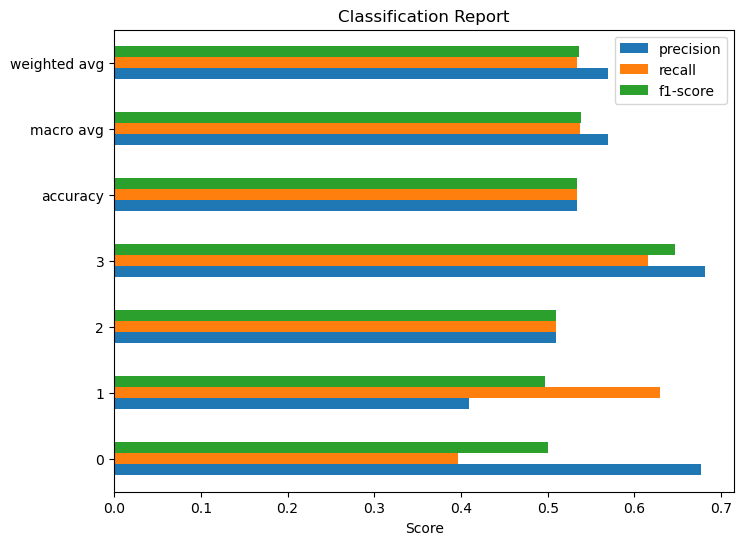

In [22]:
import pandas as pd

# 분류 보고서를 데이터프레임으로 변환
report = classification_report(actual_labels, predicted_labels, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# 분류 보고서 시각화
#df_report.drop(['accuracy'], inplace=True)  # 'accuracy' row는 제외하고 시각화
df_report['support'] = df_report['support'].apply(int)  # support를 정수로 변환

fig, ax = plt.subplots(figsize=(8, 6))
df_report[['precision', 'recall', 'f1-score']].plot(kind='barh', ax=ax)
ax.set_title('Classification Report')
ax.set_xlabel('Score')
plt.show()

In [23]:
'''
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, filepath)

save_checkpoint(model, optimizer, epoch, train_loss, './Acc76.pth')
'''

"\ndef save_checkpoint(model, optimizer, epoch, loss, filepath):\n    torch.save({\n        'epoch': epoch,\n        'model_state_dict': model.state_dict(),\n        'optimizer_state_dict': optimizer.state_dict(),\n        'loss': loss,\n    }, filepath)\n\nsave_checkpoint(model, optimizer, epoch, train_loss, './Acc76.pth')\n"

In [24]:
'''
def load_checkpoint(filepath, model, optimizer):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, optimizer, epoch, loss

# 모델과 옵티마이저 인스턴스를 생성한 뒤, 체크포인트 로드
model = TransformerModel(input_size, num_classes, device=device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# 체크포인트 파일 로드
model, optimizer, start_epoch, last_loss = load_checkpoint('model_checkpoint.pth', model, optimizer)
'''

"\ndef load_checkpoint(filepath, model, optimizer):\n    checkpoint = torch.load(filepath)\n    model.load_state_dict(checkpoint['model_state_dict'])\n    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])\n    epoch = checkpoint['epoch']\n    loss = checkpoint['loss']\n    return model, optimizer, epoch, loss\n\n# 모델과 옵티마이저 인스턴스를 생성한 뒤, 체크포인트 로드\nmodel = TransformerModel(input_size, num_classes, device=device).to(device)\noptimizer = torch.optim.Adam(model.parameters(), lr=0.0001)\n\n# 체크포인트 파일 로드\nmodel, optimizer, start_epoch, last_loss = load_checkpoint('model_checkpoint.pth', model, optimizer)\n"

: 